In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-03-01 01:28:15.716227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load your data
df = pd.read_csv('sorted_stock_data_cleaned_nica.csv')  # Replace with your file
print(df.head())


    Open   High    Low  Close  per_change     Qty    EPS         PE
0  678.0  666.0  658.0  660.0         0.0  3547.0  17.94  36.789298
1  660.0  660.0  647.0  651.0         0.0  5758.0  17.94  36.287625
2  651.0  655.0  644.0  646.0         0.0  6085.0  17.94  36.008919
3  646.0  651.0  642.0  648.0         0.0  6977.0  17.94  36.120401
4  648.0  651.0  643.0  648.0         0.0  3303.0  17.94  36.120401


In [3]:
# Ensure all 8 columns are present (adjust if needed)
feature_columns = ['Open', 'High', 'Low', 'Close', 'per_change', 'Qty', 'EPS', 'PE']  # Your 8 features
data = df[feature_columns].values

In [4]:
# Scale all 8 features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
# Sequence creation function
def create_sequences_multivariate(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])   # n_steps timesteps, each with 8 features
        y.append(data[i+n_steps])      # Predict all 8 features at next step
    return np.array(X), np.array(y)

In [6]:
# Parameters
n_steps = 60  # Past 60 days used for prediction


In [7]:
# Create sequences
X, y = create_sequences_multivariate(scaled_data, n_steps)

In [8]:
# Train-test split
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Define Bidirectional LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps, 8)),
    Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(8)
    
])
# model.add(LSTM(128, return_sequences=True), input_shape=(n_steps, 8))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(64, return_sequences=False)))
# model.add(Dropout(0.3))
# model.add(Dense(8))  # Predict all 8 features at once

In [10]:
model.compile(optimizer='adam', loss='mse')

In [11]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]


In [12]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=callbacks)

Epoch 1/100
21/21 [==============================] - 9s 189ms/step - loss: 0.0538 - val_loss: 0.0121 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 3s 126ms/step - loss: 0.0195 - val_loss: 0.0093 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 3s 124ms/step - loss: 0.0162 - val_loss: 0.0075 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 3s 129ms/step - loss: 0.0136 - val_loss: 0.0061 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 3s 121ms/step - loss: 0.0125 - val_loss: 0.0054 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 3s 121ms/step - loss: 0.0127 - val_loss: 0.0052 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 3s 125ms/step - loss: 0.0115 - val_loss: 0.0054 - lr: 0.0010
Epoch 8/100
21/21 [==============================] - 3s 127ms/step - loss: 0.0110 - val_loss: 0.0056 - lr: 0.0010
Epoch 9/100
21/21 [==============================] - 3s 123ms/step - loss: 0.0105 - val_

In [13]:
model.save('final_model_60.keras')

In [14]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
model = load_model('final_model_60.keras')

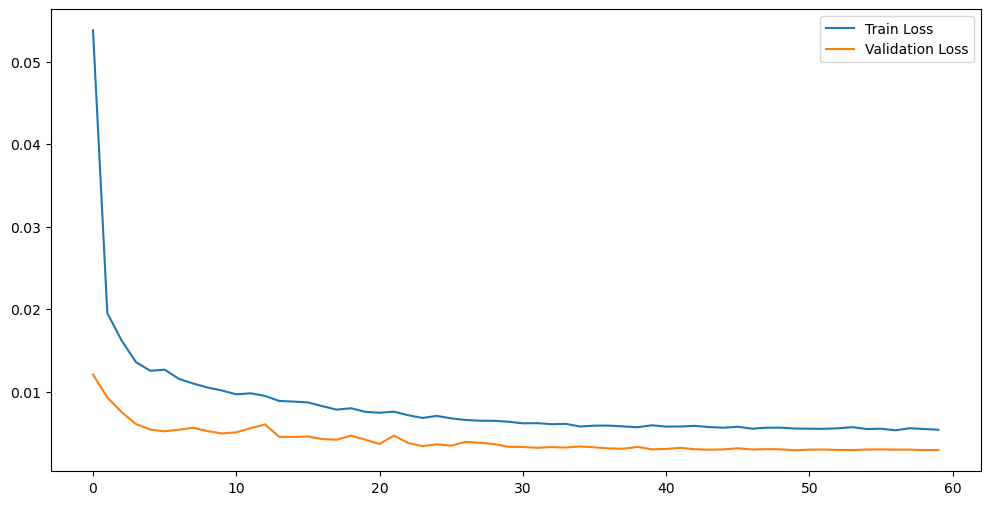

In [15]:

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [16]:
## for the X_train
train_result=model.predict(X_train)
train_result_inverse=scaler.inverse_transform(train_result)
train_result_close=train_result_inverse[:, 3]


53/53 [==============================] - 2s 28ms/step


In [ ]:
## for the X_test
test_result=model.predict(X_test)
test_result_inverse=scaler.inverse_transform(test_result)
test_result_close=test_result_inverse[:, 3]


6/6 [==============================] - 0s 28ms/step


In [57]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
print("MAE of close:", mean_absolute_error(y_test[:,3], test_result[:,3]))
print("R² Score of close:", r2_score(y_test[:,3], test_result[:,3]))
print("MSE of close:", mean_squared_error(y_test[:,3], test_result[:,3]))
print("MAPE of close:", mean_absolute_percentage_error(y_test[:,3], test_result[:,3]))


MAE of close: 0.035791927503394126
R² Score of close: 0.562151192371178
MSE of close: 0.0018436303632584877
MAPE of close: 0.23696074690426025
